[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Let's create a list of messages. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message types, as discussed above.

There are [many](https://python.langchain.com/v0.2/docs/concepts/#chat-models) to choose from! Let's work with Google Gen AI. 

Let's check that your `GOOGLE_API_KEY` is set and, if not, you will be asked to enter it.

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

We can load a chat model and invoke it with out list of messages.

We can see that the result is an `AIMessage` with specific `response_metadata`.

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [6]:
from IPython.display import Markdown, display

display(Markdown(result.content))

The best place to see Orcas in the US is **the San Juan Islands in Washington State**.

Here's why:

*   **Resident Orca Populations:** The San Juan Islands are home to the Southern Resident Killer Whale population, which includes three distinct pods: J, K, and L. These orcas are known for their predictable movements and are frequently sighted in the waters around the islands.
*   **Abundant Prey:** The primary food source for these resident orcas is Chinook salmon, which are abundant in the Salish Sea. This creates a reliable feeding ground for the whales.
*   **Clear Waters:** The waters in the San Juan Islands are relatively clear, offering excellent visibility for whale watching.
*   **Established Whale Watching Industry:** There's a well-developed and responsible whale watching industry in the area, with many operators dedicated to ethical viewing practices.

**When to go:**

The prime whale watching season for the Southern Resident Orcas in the San Juan Islands is typically from **late May through September**. However, sightings can occur outside of this window, and other whale species like transient orcas (Bigg's killer whales) are present year-round.

**Important Considerations for Orca Watching in the San Juan Islands:**

*   **Responsible Whale Watching:** It's crucial to choose tour operators who follow strict guidelines to minimize disturbance to the whales. Look for companies that maintain a safe distance, avoid sudden movements, and turn off their engines when near the animals.
*   **Respect the Wildlife:** Always follow the instructions of your captain and crew. Never try to feed or touch the whales.
*   **Other Marine Life:** While orcas are the main draw, you're also likely to see other incredible marine life, including Minke whales, humpback whales, seals, sea lions, porpoises, and a variety of seabirds.

**Other potential, though less consistent, places to see Orcas in the US:**

*   **Alaska:** Particularly in Southeast Alaska (e.g., Glacier Bay, Juneau, Sitka), transient orcas are frequently seen, often in conjunction with whale watching tours focused on humpbacks. While you can see orcas here, the San Juan Islands offer a more reliable chance of seeing the *resident* populations.
*   **Hawaii:** Transient orcas are sometimes spotted in Hawaiian waters, but these sightings are much rarer and less predictable than in the Pacific Northwest.

**In summary, if your primary goal is to see Orcas in the US, the San Juan Islands of Washington State are your best bet.**

In [7]:
result.response_metadata

{'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
 'finish_reason': 'STOP',
 'model_name': 'gemini-2.5-flash-lite',
 'safety_ratings': []}

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user. 

And, it will return an output that adheres to the tool's schema. 

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 
 
You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of tool calling!
 
The `multiply` function is our tool.

In [9]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a tool call returned. 

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [10]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 18 multiplied by 3", name="Lance")])

In [11]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'b': 3, 'a': 18},
  'id': 'f8bc7657-8454-4e3a-860a-50b8112c6a7b',
  'type': 'tool_call'}]

## Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [12]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem! 

As we discussed, each node will return a new value for our state key `messages`.

But, this new value [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.
 
As our graph runs, we want to **append** messages to our `messages` state key.
 
We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.
 
But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [13]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects 
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [14]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [15]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='763c2447-d340-4983-b864-53d744060ff0'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='147253c7-e605-4050-890b-5dc9386e0d72'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='c8a11d5c-4e07-4e52-8daa-c0497e43409b')]

## Our graph

Now, lets use `MessagesState` with a graph.

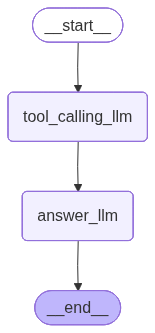

In [19]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Node for generating a contextual answer after the tool call
def answer_llm(state: MessagesState):
    # The LLM sees the full message history, including the tool result
    return {"messages": [llm.invoke(state["messages"])]}
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("answer_llm", answer_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", "answer_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [20]:
messages = graph.invoke({"messages": HumanMessage(content="Are you good at math ?")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Are you good at math ?
================================== Ai Message ==================================

I can help with basic math operations like multiplication. What do you need help with?
================================== Ai Message ==================================


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [22]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 19 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 19 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (d6382aaa-0ef9-4d5e-97d3-3593a717a729)
 Call ID: d6382aaa-0ef9-4d5e-97d3-3593a717a729
  Args:
    b: 3
    a: 19
================================== Ai Message ==================================

19 multiplied by 3 is 57.
